# Sleep Apnea Detection

This project was part of the Machine Learning Health Technology Project course in University of Turku. 

Data was given along with the assignment and it includes a single channel ECG signal measured during sleep. 

- Sampling rate is 100hz and samples are 30 seconds long.
- Objective of the project was to create a model that can detect sleep apnea using HRV features extracted from ECG data. 
> Sleep apnea is a medical condition where the person suffers from intermittent breathing cessations during sleep. It's correlated with increased mortality rate, myocardial infarctions, and increased blood pressure.


In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import neurokit2 as nk
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## Data loading

We begin by first globbing and reading the data from text files. We do this by writing a simple read_txt function that we use to iterate through the lists.

We begin by reading the ECG signals from .txt files using a custom read_txt function and glob.
Normal and Apnea signals are separated in their own directories.

In [2]:
datadir = Path("data")

apnea_train = list((datadir / "Train/apnea").glob("*.txt"))
normal_train = list((datadir / "Train/normal").glob("*.txt"))
apnea_test = list((datadir / "Test/apnea").glob("*.txt"))
normal_test = list((datadir / "Test/normal").glob("*.txt"))

def read_txt(data):
    signals = []
    for i in data:
        df = pd.read_csv(i, header=None)
        signals.append(df.squeeze())
    return signals

apnea_train = read_txt(apnea_train)
normal_train = read_txt(normal_train)
apnea_test = read_txt(apnea_test)
normal_test = read_txt(normal_test)


## Filtering & Peak detection

We apply a Butterworth band-pass filter (0.5-40 Hz) to remove baseline wandering and high frequency noise. We're also utilizing neurokit2's ecg_peaks to locate R-peaks in the filtered signals.

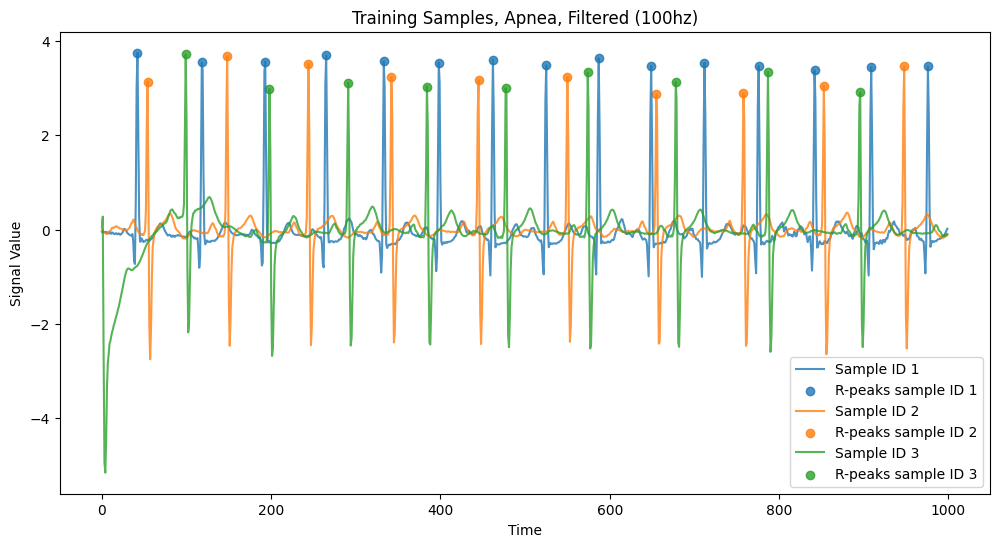

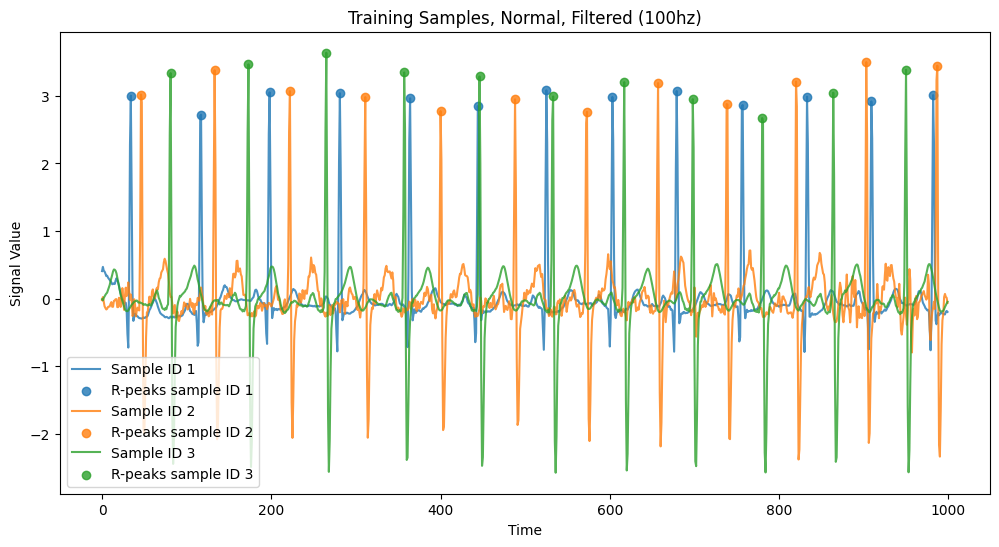

In [3]:
def butter_bandpass(signal, lowcut=0.5, highcut=40.0, fs=100, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def find_peaks(filtered_signal):
    r_peaks_list = []
    for signal in filtered_signal:
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=100)
        r_peaks_list.append(rpeaks["ECG_R_Peaks"])
    return r_peaks_list

def plot_signals(signals, peaks_list, title, n=3):
    plt.figure(figsize=(12, 6))
    for i in range(min(n, len(signals))):
        plt.plot(signals[i][:1000], label=f"Sample ID {i+1}", alpha=0.8)
        p = [idx for idx in peaks_list[i] if idx < 1000]
        plt.scatter(p, signals[i][p], label=f"R-peaks sample ID {i+1}", alpha=0.8)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.show()

def preprocess(signals):
    filtered = [butter_bandpass(signal) for signal in signals]
    peaks = find_peaks(filtered)
    return filtered, peaks

normal_train_filtered, normal_train_peaks = preprocess(normal_train)
normal_test_filtered, normal_test_peaks = preprocess(normal_test)
apnea_train_filtered, apnea_train_peaks = preprocess(apnea_train)
apnea_test_filtered, apnea_test_peaks = preprocess(apnea_test)

plot_signals(apnea_train_filtered, apnea_train_peaks, "Training Samples, Apnea, Filtered (100hz)", n=3)
plot_signals(normal_train_filtered, normal_train_peaks, "Training Samples, Normal, Filtered (100hz)", n=3)

Here we check that the neurokit2's hrv method is correctly computing the HRV data for our peaks' data

In [4]:
display(nk.hrv(normal_train_peaks[0], sampling_rate=100))
display(nk.hrv(apnea_train_peaks[0], sampling_rate=100))

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,729.463415,56.392832,31.709268,48.056122,NaN,NaN,NaN,NaN,41.53827,41.588791,...,0.670471,4.398715,0.657654,1.571628,1.316578,1.81741,1.549751,1.628194,2.292082,0.613914


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,771.185567,78.665462,23.552723,75.38626,NaN,NaN,NaN,NaN,40.04842,40.099253,...,0.876685,4.739912,0.648681,1.383256,1.313187,2.138309,1.699027,1.429097,2.46474,0.465459


## Feature extraction

In [5]:
X_train_hrv = []
for peak in normal_train_peaks + apnea_train_peaks:
    HRV_data = nk.hrv(peak, sampling_rate=100)
    X_train_hrv.append(HRV_data.iloc[0])

In [6]:
X_test_hrv = []
for peak in normal_test_peaks + apnea_test_peaks:
    HRV_data = nk.hrv(peak, sampling_rate=100)
    X_test_hrv.append(HRV_data.iloc[0])

Here we do the features and labels for our models' data. We label normal ECGs with 0 and apnea ECGs with 1. After creating the model data we standardize it.

In [7]:
X_train = pd.DataFrame(X_train_hrv)
y_train = np.array([0] * len(normal_train) + [1] * len(apnea_train))
X_test = pd.DataFrame(X_test_hrv)
y_test = np.array([0] * len(normal_test) + [1] * len(apnea_test))

In [8]:
X_train.info()
X_test.info()
# ['HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5, 'HRV_SDNNI5', 'HRV_ULF'] are completely empty
X_train.dropna(axis=1, how='all', inplace=True)
X_test.dropna(axis=1, how='all', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, 0 to 0
Data columns (total 91 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   HRV_MeanNN                    624 non-null    float64
 1   HRV_SDNN                      624 non-null    float64
 2   HRV_SDANN1                    624 non-null    float64
 3   HRV_SDNNI1                    624 non-null    float64
 4   HRV_SDANN2                    0 non-null      float64
 5   HRV_SDNNI2                    0 non-null      float64
 6   HRV_SDANN5                    0 non-null      float64
 7   HRV_SDNNI5                    0 non-null      float64
 8   HRV_RMSSD                     624 non-null    float64
 9   HRV_SDSD                      624 non-null    float64
 10  HRV_CVNN                      624 non-null    float64
 11  HRV_CVSD                      624 non-null    float64
 12  HRV_MedianNN                  624 non-null    float64
 13  HRV_MadNN   

## Model selection
Choosing the models and their parameter distributions for later use with Pipeline and RandomizedSearch

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
models = {
    'DummyClassifier' : {
        'estimator' : DummyClassifier(random_state=42),
        'params' : {
            'clf__strategy' : ['most_frequent', 'stratified', 'uniform']
        }
    },
    'RandomForest' : {
        'estimator' : RandomForestClassifier(random_state=42),
        'params' : {
            'clf__n_estimators': randint(100, 1201),
            'clf__max_depth': [None] + list(np.arange(1, 31)),
            'clf__min_samples_split': randint(2, 8),
            'clf__min_samples_leaf': randint(1, 8),
            'clf__bootstrap': [True, False]
        }
    },
    'XGBoost' : {
        'estimator' : XGBClassifier(eval_metric='logloss', random_state=42),
        'params' : {
            'clf__n_estimators': randint(100, 1201),
            'clf__max_depth': randint(0, 7),
            'clf__learning_rate': uniform(0.01, 0.3),
            'clf__subsample': uniform(0.01, 0.9),
            'clf__colsample_bytree': uniform(0.01, 0.8),
            'clf__gamma' : uniform(0, 10)
        } 
    },
    'GradientBoostingClassifier' : {
        'estimator' : GradientBoostingClassifier(random_state=42),
        'params' : {
            'clf__n_estimators': randint(200, 2000),
            'clf__learning_rate': uniform(0.005, 0.3),
            'clf__max_depth': randint(2, 6),
            'clf__min_samples_split': randint(2, 20),
            'clf__min_samples_leaf': randint(1, 20),
            'clf__subsample': uniform(0.5, 0.5),
            'clf__max_features': ['sqrt', 'log2', None]
        }
    }
}

## Pipeline, Nested CV with RandomizedSearchCV
Creating a pipeline with SimpleImputer to fill possible empty values with medians and StandardScaler to scale the features. We choose RandomizedSearch instead of GridSearch to reduce compute time. We validate the models with outer CV by running cross_val_score

In [10]:
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

model_scores = {}

for name, cfg in models.items():
    print(f"\n --- \n Now tuning {name}\n --- \n")
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', cfg['estimator'])
    ])
    randomsearch = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=cfg['params'],
        cv=inner_cv,
        scoring='recall',
        n_iter=30,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    scores = cross_val_score(randomsearch, X_train, y_train, cv=outer_cv, scoring='recall', n_jobs=1)
    model_scores[name] = f"Mean {np.mean(scores)} +- {np.std(scores)} std"

model_scores



 --- 
 Now tuning DummyClassifier
 --- 

Fitting 4 folds for each of 3 candidates, totalling 12 fits


c:\Users\tinpp\Documents\Code\Notebooks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\tinpp\Documents\Code\Notebooks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 3 candidates, totalling 12 fits


c:\Users\tinpp\Documents\Code\Notebooks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\tinpp\Documents\Code\Notebooks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\tinpp\Documents\Code\Notebooks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\tinpp\Documents\Code\Notebooks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use

Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Fitting 4 folds for each of 3 candidates, totalling 12 fits

 --- 
 Now tuning RandomForest
 --- 

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits

 --- 
 Now tuning XGBoost
 --- 

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Fitti

{'DummyClassifier': 'Mean 0.6108985260770976 +- 0.0030105790513390213 std',
 'RandomForest': 'Mean 0.7237103174603176 +- 0.06685967365315565 std',
 'XGBoost': 'Mean 0.7234977324263038 +- 0.05642316335697349 std',
 'GradientBoostingClassifier': 'Mean 0.7648100907029477 +- 0.05282865226497538 std'}

## Training the best performing model

In [11]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', models['GradientBoostingClassifier']['estimator'])
])

randomsearch_final = RandomizedSearchCV(
        estimator = pipe,
        param_distributions = models['GradientBoostingClassifier']['params'],
        cv = inner_cv,
        scoring = 'recall',
        n_iter = 300,
        n_jobs = -1,
        verbose = 2,
        random_state = 42
)

randomsearch_final.fit(X_train, y_train)
print(randomsearch_final.best_params_)
print(randomsearch_final.best_score_) 

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
{'clf__learning_rate': np.float64(0.21372460669538515), 'clf__max_depth': 4, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 17, 'clf__n_estimators': 670, 'clf__subsample': np.float64(0.522723190170729)}
0.7747130692336172


In [12]:

y_pred = randomsearch_final.predict(X_test)
print("Final predictions for test set")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall (sensitivity):", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Final predictions for test set
Accuracy: 0.8076923076923077
Recall (sensitivity): 0.8533333333333334
Precision: 0.7710843373493976
F1: 0.810126582278481


### Evaluation
Performance was evaluated using Accuracy, Precision, Recall, F1-score and ROC+AUC



Here is a plot for the Confusion Matrices.

In [13]:
final_classification = classification_report(y_test, y_pred)
final_confusion = confusion_matrix(y_test, y_pred)

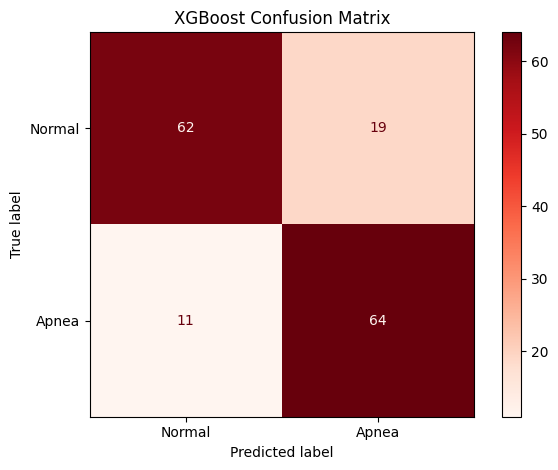

In [14]:
ConfusionMatrixDisplay(final_confusion, display_labels=['Normal', 'Apnea']).plot(cmap='Reds')
plt.title('XGBoost Confusion Matrix')

plt.tight_layout()
plt.show()

Here are the classification reports' stats.

Finally, let's plot the ROC Curve for both models.

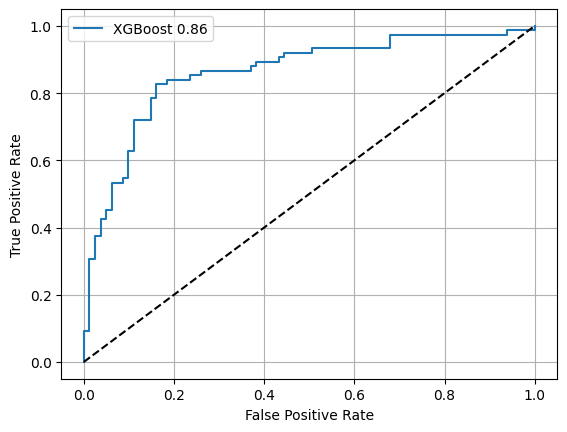

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        81
           1       0.77      0.85      0.81        75

    accuracy                           0.81       156
   macro avg       0.81      0.81      0.81       156
weighted avg       0.81      0.81      0.81       156



In [15]:

final_probs = randomsearch_final.predict_proba(X_test)[:, 1]
final_fpr, final_tpr, _ = roc_curve(y_test, final_probs)
final_auc = auc(final_fpr, final_tpr)

plt.plot(final_fpr, final_tpr, label=f'XGBoost {final_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

print(final_classification)


# Conclusion

| Model         | Accuracy | F1 (Apnea) | ROC-AUC |
|---------------|----------|------------|---------|
| Dummy (majority) | 0.52 | 0.00 | 0.50 |
| RandomForest  | **0.82** | **0.82** | **0.88** |
| XGBoost       | 0.782 | 0.78 | 0.87 |

When detecting sleep apnea with this data set, we can see that RandomForest is performing better. Data got filtered using Butterworth band-pass and ECG got handled using neurokit2's methods. After adjusting the selected HRV features to be used with the models we found that involving neurokit2's HRV method's all features brought the best results.